# Applying the bilinear system identification Landau-Zener 

In [1]:
from qutip import *
import matplotlib.pyplot as plt
from bi_sys_id_quantum import *

In [2]:
def get_quantum_expectation(pulse, times):
    """
    Calculate the time-series for the expectation value of a quantum observable 
    pulse - a function of two arguments
    """
    Hamiltonian = [sigmaz(), [sigmax(), pulse]]
    
    return mesolve(
        Hamiltonian, basis(2, 0), times, [], [sigmax(), sigmay(),] #[0.001 * sigmaz() + sigmax()]
    ).expect

In [3]:
p = 100
dt = 0.01
F = 20.

times = dt * np.arange(500)

In [4]:
original_responses = [
    [
        get_quantum_expectation(lambda t, args: F * (t < N * dt), times)
    ] for N in range(1, p + 1)    
]

original_responses = np.array(original_responses)

In [5]:
original_responses.shape

(100, 1, 2, 500)

In [6]:
#rank, sigma = estimate_rank(original_responses, alpha=int(original_responses.shape[1] / 2))

In [7]:
"""
plt.title("$y^{(N)}(t)$ Input/Original Responses")
plt.plot(original_responses.T)
plt.xlabel("Time in units of $\Delta t$")
plt.ylabel("Responses")
plt.savefig('input.pdf')
#plt.xlim(0, 200)
plt.show()
"""

'\nplt.title("$y^{(N)}(t)$ Input/Original Responses")\nplt.plot(original_responses.T)\nplt.xlabel("Time in units of $\\Delta t$")\nplt.ylabel("Responses")\nplt.savefig(\'input.pdf\')\n#plt.xlim(0, 200)\nplt.show()\n'

In [8]:
reconstructed = bi_sys_id_my_version(
    original_responses, 
    alpha = int(original_responses.shape[-1] / 2),
    dt = dt,
    v = [F],
    #rank=4.
    #enforce_orthogonal=True
)

In [9]:
reconstructed

Reconstructed(Ac=array([[-1.20257111e-10,  1.81491151e+00],
       [-2.20393214e+00,  1.77586979e-10]]), C=array([[-0.43928517,  0.29771616],
       [ 0.32807549,  0.39863476]]), Nc=[array([[-6.31202254,  4.14269234],
       [-9.31581988,  6.11225816]])], x0=array([[-0.33605501],
       [-0.49307511]]))

In [10]:
reconstructed_responses = get_training_responses(reconstructed, times, p, [F])

In [11]:
np.abs(reconstructed_responses.reshape(-1) - original_responses.reshape(-1)).max()

1.1638770600338084

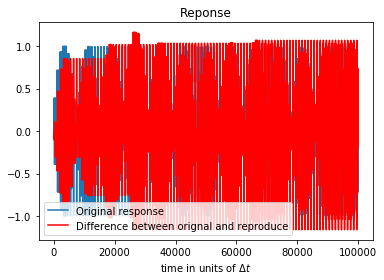

In [12]:
plt.title('Reponse')
plt.plot(original_responses.reshape(-1), label='Original response')
plt.plot(
    reconstructed_responses.reshape(-1) - original_responses.reshape(-1), 
    'r', label='Difference between orignal and reproduce'
)
plt.xlabel("time in units of $\Delta t$")
plt.legend()
plt.show()

In [13]:
"""
plt.title("Original responses")
plt.plot(original_responses.T)
plt.xlabel("time in units of $\Delta t$")
plt.ylabel("$\\langle \sigma_z + \sigma_x \\rangle$ \t(a.u.)")
plt.savefig('input.pdf')
plt.show()

plt.title("Reconstructed responses")
plt.plot(reconstructed_responses.T)
plt.xlabel("time in units of $\Delta t$")
plt.ylabel("$\\langle \sigma_z + \sigma_x \\rangle$ \t(a.u.)")
plt.savefig('response.pdf')
plt.show()
"""

'\nplt.title("Original responses")\nplt.plot(original_responses.T)\nplt.xlabel("time in units of $\\Delta t$")\nplt.ylabel("$\\langle \\sigma_z + \\sigma_x \\rangle$ \t(a.u.)")\nplt.savefig(\'input.pdf\')\nplt.show()\n\nplt.title("Reconstructed responses")\nplt.plot(reconstructed_responses.T)\nplt.xlabel("time in units of $\\Delta t$")\nplt.ylabel("$\\langle \\sigma_z + \\sigma_x \\rangle$ \t(a.u.)")\nplt.savefig(\'response.pdf\')\nplt.show()\n'

## Testing the reconstructed model

In [14]:
pulse = lambda t, args=0: 200. * np.sin(70. * t) # 1e-2* np.sin(2 * (t + 0.5 * t ** 2))

In [15]:
#import copy
#model = copy.deepcopy(reconstructed)
#model.Ac[:] = 0.5 * (model.Ac - model.Ac.conj().T)
#model.Nc[0][:] = 0.5 * (model.Nc[0] - model.Nc[0].conj().T)
model = reconstructed

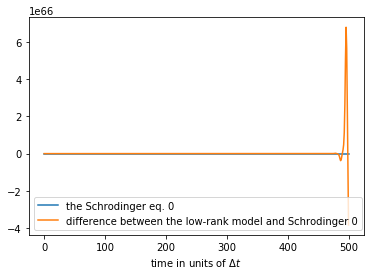

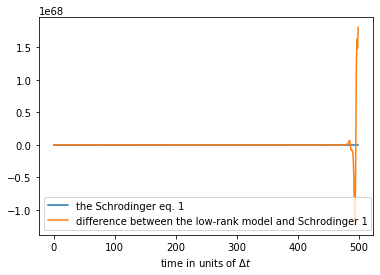

In [16]:
for num, (exact, predicted) in enumerate(zip(get_quantum_expectation(pulse, times), get_response(model, pulse, times))):
    plt.plot(exact, label='the Schrodinger eq. {}'.format(num))
    plt.plot(exact - predicted, label='difference between the low-rank model and Schrodinger {}'.format(num))

    plt.xlabel("time in units of $\Delta t$")
    #plt.ylabel("$\\langle \sigma_z + \sigma_x \\rangle$ \t(a.u.)")

    plt.legend()
    plt.savefig('Fig_LandauZener_Test.pdf')

    plt.show()

In [17]:
np.linalg.eig(model.Ac)

(array([2.86649339e-11+1.99998545j, 2.86649339e-11-1.99998545j]),
 array([[5.00390813e-11-0.67201222j, 5.00390813e-11+0.67201222j],
        [7.40540055e-01+0.j        , 7.40540055e-01-0.j        ]]))

In [18]:
(
    tensor(qeye(2), sigmaz()) - tensor(sigmaz(), qeye(2))
).eigenenergies()

array([-2.,  0.,  0.,  2.])

In [19]:
(
    tensor(qeye(2), sigmax()) - tensor(sigmax(), qeye(2))
).eigenenergies()

array([-2.0000000e+00,  0.0000000e+00,  6.9388939e-18,  2.0000000e+00])

In [20]:
np.linalg.eig(model.Nc[0])

(array([-0.09988219+0.04344972j, -0.09988219-0.04344972j]),
 array([[0.55479456-0.00388041j, 0.55479456+0.00388041j],
        [0.83197833+0.j        , 0.83197833-0.j        ]]))

In [21]:
reconstructed.Ac

array([[-1.20257111e-10,  1.81491151e+00],
       [-2.20393214e+00,  1.77586979e-10]])

In [22]:
"""
    l = 20 - 4

    transpose = np.array(
        [[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]
    )
        
    Phi = np.block([
        [0.5 * (np.eye(4) + transpose), np.zeros((4, l))],
        [np.zeros((l, 4)), np.eye(l)],
    ])

    Phi[1, -1] = Phi[2, -2] = Phi[-1, 1] = Phi[-2, 2] = 0.5
"""

'\n    l = 20 - 4\n\n    transpose = np.array(\n        [[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]\n    )\n        \n    Phi = np.block([\n        [0.5 * (np.eye(4) + transpose), np.zeros((4, l))],\n        [np.zeros((l, 4)), np.eye(l)],\n    ])\n\n    Phi[1, -1] = Phi[2, -2] = Phi[-1, 1] = Phi[-2, 2] = 0.5\n'

## Following Kurt's idea to feed the whole wave function -- DOESN'T WORK

I belive for this to work we need to add $\mathbf{d}_0$ to the algorithm.

In [23]:
def rand_hermitian():
    """
    Random hermitian matrix with [-1, +1] as the eigenvals
    
    NOTE it is VERY IMPORTANT that the observables must have [-1, +1] as eigenvals for the SI to work!!!!
    (this was found empirically)
    """
    rand_h = np.random.rand(4).reshape((2, 2)) + 1j * np.random.rand(4).reshape((2, 2))
    rand_h += rand_h.T
    rand_h *= 0.5
    rand_h -= np.trace(rand_h) * 0.5 * np.eye(2)
    min_val, max_val = np.linalg.eigvalsh(rand_h)
    rand_h /= max_val
    
    return rand_h 

rand_observables = [Qobj(rand_hermitian()) for _ in range(3)]

In [24]:
rand_observables


[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
 Qobj data =
 [[ 0.117208  +0.23421306j  0.56707244+0.81528592j]
  [ 0.56707244+0.81528592j -0.117208  -0.23421306j]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
 Qobj data =
 [[ 0.62024964+0.5502444j   0.33082162+0.71122953j]
  [ 0.33082162+0.71122953j -0.62024964-0.5502444j ]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
 Qobj data =
 [[-0.10879672+0.34224688j  0.5794495 +0.80771378j]
  [ 0.5794495 +0.80771378j  0.10879672-0.34224688j]]]

In [25]:
def get_quantum_expectation(pulse, times):
    """
    Calculate the time-series for the expectation value of a quantum observable 
    pulse - a function of two arguments
    """
    Hamiltonian = [sigmaz(), [sigmax(), pulse]]
    
    return sesolve(
        Hamiltonian, basis(2, 0), times, rand_observables 
    ).expect

In [26]:
original_responses = [
    [
        get_quantum_expectation(lambda t, args: F * (t < N * dt), times)
    ] for N in range(1, p + 1)    
]

original_responses = np.array(original_responses)

In [27]:
original_responses.shape

(100, 1, 3, 500)

In [28]:
reconstructed = bi_sys_id_my_version(
    original_responses, 
    alpha = int(original_responses.shape[-1] / 2),
    dt = dt,
    v = [F],
    #rank=4
)

In [29]:
reconstructed_responses = get_training_responses(reconstructed, times, p, [F])

In [30]:
np.abs(reconstructed_responses.reshape(-1) - original_responses.reshape(-1)).max()

8.463593631884015e-05

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


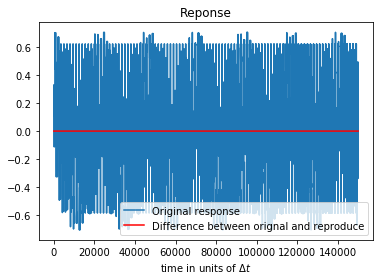

In [31]:
plt.title('Reponse')
plt.plot(original_responses.reshape(-1), label='Original response')
plt.plot(
    reconstructed_responses.reshape(-1) - original_responses.reshape(-1), 
    'r', label='Difference between orignal and reproduce'
)
plt.xlabel("time in units of $\Delta t$")
plt.legend()
plt.show()

In [32]:
reconstructed

Reconstructed(Ac=array([[ 0.02582673-0.00160426j,  0.17845464-0.01769223j,
        -0.08766276+0.0025883j ],
       [ 0.35404759-0.00729301j, -0.15595702+0.00418247j,
        -1.97365448+0.01106663j],
       [ 0.08861004+0.00210423j,  2.0652496 +0.00724831j,
         0.13013029-0.00257821j]]), C=array([[-0.14462515-0.26800991j,  0.21524544+0.31124585j,
         0.21206845+0.30272646j],
       [-0.6382224 -0.57599659j,  0.15423894+0.28788837j,
         0.17786023+0.29053736j],
       [ 0.07973093-0.37694343j,  0.20866151+0.31435296j,
         0.19708068+0.31196775j]]), Nc=[array([[ 0.29515659-0.02448254j,  0.65796471+0.00522301j,
        -0.69934269+0.00351121j],
       [-2.93246964+0.02209346j,  0.1110274 -0.00671391j,
         0.30094495-0.02836639j],
       [ 3.13395253-0.01142486j, -0.03423975+0.00484338j,
        -0.40618388+0.03119645j]])], x0=array([[-1.01584786-0.00463611j],
       [ 0.05533492+0.00068457j],
       [-0.18662625+0.00193881j]]))

In [33]:
F

20.0

## Testing the reconstructed model

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


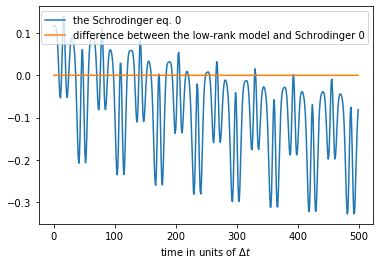

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


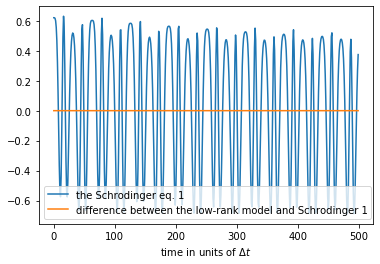

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


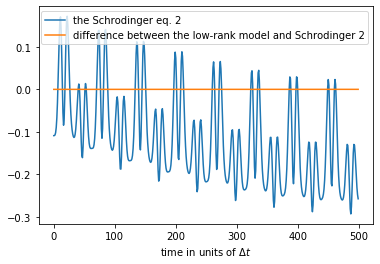

In [34]:
pulse = lambda t, args=0: 30. * np.sin(10. * t) 

model = reconstructed

for num, (exact, predicted) in enumerate(zip(get_quantum_expectation(pulse, times), get_response(model, pulse, times))):
    plt.plot(exact, label='the Schrodinger eq. {}'.format(num))
    plt.plot(exact - predicted, label='difference between the low-rank model and Schrodinger {}'.format(num))

    plt.xlabel("time in units of $\Delta t$")
    #plt.ylabel("$\\langle \sigma_z + \sigma_x \\rangle$ \t(a.u.)")

    plt.legend()
    #plt.savefig('Fig_LandauZener_Test.pdf')

    plt.show()